In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Jun  9 21:20:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import pickle
import torchvision
from torchvision import transforms
import torchvision.datasets as dset
from torchvision import transforms
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import numpy as np
import sys
from collections import deque
import os
import pandas as pd
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import os
from numpy.random import choice as npc
import numpy as np
import time
import random
import torchvision.datasets as dset
from PIL import Image
import pandas as pd
import cv2

In [ ]:


class ImplantTrain(Dataset):

    def __init__(self, train_df, dataPath, transform=None):
        super(ImplantTrain, self).__init__()
        np.random.seed(0)
        # self.dataset = dataset
        self.transform = transform
        self.train_df = train_df
        
        self.num_classes = len(next(os.walk(dataPath))[1])
        self.classes = [item for item in os.listdir(dataPath) if os.path.isdir(os.path.join(dataPath, item))]
        self.data_paths = {}
        idx = 0
        self.label_mapper = {'Viper':0, 'Legacy':1, 'Xia':2, 'Reline':3, 'M8M10':4, 'Isola':5}
        for i in range(train_df.shape[0]):
            if train_df['Product'].iloc[i] not in list(self.data_paths.keys()):
                self.data_paths[train_df['Product'].iloc[i]] = []
            self.data_paths[train_df['Product'].iloc[i]].append(train_df['file_path'].iloc[i])

    def __len__(self):
        return len(self.train_df)

    def __getitem__(self, index):
        # image1 = random.choice(self.dataset.imgs)
        label = None
        img1 = None
        img2 = None
        # get image from same class
        if index % 2 == 1:
            label = 1.0
            idx1 = list(self.data_paths.keys())[random.randint(0, self.num_classes - 1)]
            image1 = Image.open(random.choice(self.data_paths[idx1]))
            image2 = Image.open(random.choice(self.data_paths[idx1]))
            #print(image1.shape)
            #print(image2.shape)
        # get image from different class
        else:
            label = 0.0
            idx1 = list(self.data_paths.keys())[random.randint(0, self.num_classes - 1)]
            idx2 = list(self.data_paths.keys())[random.randint(0, self.num_classes - 1)]
            while idx1 == idx2:
                idx2 = list(self.data_paths.keys())[random.randint(0, self.num_classes - 1)]
            image1 = Image.open(random.choice(self.data_paths[idx1]))
            image2 = Image.open(random.choice(self.data_paths[idx2]))
        #print(image1.size)
        #print(image2.size)
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2, torch.from_numpy(np.array([label], dtype=np.float32))

class ImplantTest(Dataset):

    def __init__(self, test_df, dataPath, transform=None, times=200, way=20):
        np.random.seed(1)
        super(ImplantTest, self).__init__()
        self.transform = transform
        self.times = times
        self.way = way
        self.img1 = None
        self.c1 = None
        self.test_df = test_df
        
        self.num_classes = len(next(os.walk(dataPath))[1])
        self.classes = [item for item in os.listdir(dataPath) if os.path.isdir(os.path.join(dataPath, item))]
        self.data_paths = {}
        #idx = 0
        self.label_mapper = {'Viper':0, 'Legacy':1, 'Xia':2, 'Reline':3, 'M8M10':4, 'Isola':5}
        for i in range(test_df.shape[0]):
            if test_df['Product'].iloc[i] not in list(self.data_paths.keys()):
                self.data_paths[test_df['Product'].iloc[i]] = []
            self.data_paths[test_df['Product'].iloc[i]].append(test_df['file_path'].iloc[i])
        #self.datas, self.num_classes = self.loadToMem(dataPath)


    def __len__(self):
        return self.times * self.way

    def __getitem__(self, index):
        idx = index % self.way
        label = None
        # generate image pair from same class
        if idx == 0:
            self.c1 = list(self.data_paths.keys())[random.randint(0, self.num_classes - 1)]
            #self.c1 = random.randint(0, self.num_classes - 1)
            self.img1 = Image.open(random.choice(self.data_paths[self.c1]))
            img2 = Image.open(random.choice(self.data_paths[self.c1])).convert("L")
        # generate image pair from different class
        else:
            c2 = list(self.data_paths.keys())[random.randint(0, self.num_classes - 1)]
            while self.c1 == c2:
                c2 = list(self.data_paths.keys())[random.randint(0, self.num_classes - 1)]
            img2 = Image.open(random.choice(self.data_paths[c2])).convert("L")

        if self.transform:
            img1 = self.transform(self.img1)
            img2 = self.transform(img2)
        return img1, img2


# test
#if __name__=='__main__':
#    omniglotTrain = OmniglotTrain('./images_background', 30000*8)
#    print(omniglotTrain)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 128, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),    # 128@42*42
            nn.MaxPool2d(2),   # 128@21*21
            nn.Conv2d(128, 128, 4),
            nn.ReLU(), # 128@18*18
            nn.MaxPool2d(2), # 128@9*9
            nn.Conv2d(128, 256, 4),
            nn.ReLU(),   # 256@6*6
        )
        self.liner = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 1)

    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        #dis = torch.abs(out1 - out2)
        #out = self.out(dis)
        #  return self.sigmoid(out)
        return out1, out2


# for test
#if __name__ == '__main__':
#    net = Siamese()
#    print(net)
#    print(list(net.parameters()))


In [ ]:
class Siamese(nn.Module):
  def __init__(self):
    super(Siamese, self).__init__()

    self.cnn_layers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
    ).to(device)
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.25),
        nn.Linear(9216, 256),
        nn.ReLU(),
    ).to(device)
  def forward_one(self, x):
      x = self.cnn_layers(x)
      x = self.classifier(x)
      return x
  def forward(self, x1, x2):
      out1 = self.forward_one(x1)
      out2 = self.forward_one(x2)
      
      #x = self.classifier(x)
      return out1, out2
#model = ConvNET_v1().to(device)
#summary(model, input_size=(3, 256, 256))

In [ ]:

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
def get_embeddings(trainloader__, testloader__, model, train_only=True):
  train_embeddings = []
  train_labels = []
  test_embeddings = []
  test_labels = []
  net.eval()
  for i, (image, label) in enumerate(trainloader__,0): 
    with torch.no_grad():
      output = model(image)
      #output, _ = net(image, image)
    #print(output.shape)
    #print(label[0])
    #print('===')
    train_embeddings.append(output.cpu().detach().numpy())
    train_labels.append(label[0])
    del output
    #torch.cuda.empty_cache()
  train_embeddings = np.array(train_embeddings)
  train_embeddings = train_embeddings.reshape(train_embeddings.shape[0], train_embeddings.shape[2])
  if train_only == False:
    for i, (image, label) in enumerate(testloader__,0): 
      with torch.no_grad():
        output = model(image)
        #output, _ = net(image, image)
      test_embeddings.append(output.cpu().detach().numpy())
      test_labels.append(label[0])
      del output
      #torch.cuda.empty_cache()

    test_embeddings = np.array(test_embeddings)
    test_embeddings = test_embeddings.reshape(test_embeddings.shape[0], test_embeddings.shape[2])
  return train_embeddings, test_embeddings, train_labels, test_labels
def test(train_embeddings, test_embeddings, train_labels, test_labels,):
  knn = KNeighborsClassifier(n_neighbors=4, metric='euclidean')
  svc = LinearSVC()

  knn.fit(train_embeddings, train_labels)
  svc.fit(train_embeddings, train_labels)

  y_pred_knn = knn.predict(test_embeddings)
  acc_knn = accuracy_score(test_labels, y_pred_knn)
  y_pred_svc = svc.predict(test_embeddings)
  acc_svc = accuracy_score(test_labels, y_pred_svc)

  print(f'TEST:  KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

In [ ]:
from sklearn.manifold import TSNE
def embeddings(train_embeddings, train_labels):
  X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)

  plt.figure(figsize=(10,10))

  for i, t in enumerate(set(train_labels)):
      idx = np.array(train_labels) == t
      plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

  plt.legend(bbox_to_anchor=(1, 1));  
  plt.show()

In [ ]:
from torchvision import models
net = torchvision.models.densenet121(pretrained=True)
for param in net.parameters():
    param.requires_grad = True
    # Replace the last fully-connected layer
    # Parameters of newly constructed modules have requires_grad=True by default
net.classifier = nn.Linear(1024, 256) 
net.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=4.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)
torch.manual_seed(0)

Using: cuda


In [ ]:
train_path = "./drive/MyDrive/Cohort May 2021/DataSets/SiameseData_ML/train/"
test_path = "./drive/MyDrive/Cohort May 2021/DataSets/SiameseData_ML/test/"
times = 400 #number of samples to test accuracy
way = 20 # how much way one-shot learning
workers = 2 #number of dataLoader workers
batch_size = 128
lr = 0.0006
show_every = 10 #show result after each show_every iter.
save_every = 100 #save model after each save_every iter.
test_every = 100 #test model after each test_every iter.
max_iter = 50000 #number of iterations before stopping
model_path = './' #path to store model
gpu_ids = "0,1,2,3" #gpu ids used to train
cuda = True
EPOCHS = 500

In [ ]:
train_df = pd.read_csv(train_path + 'train_df.csv')
test_df = pd.read_csv(test_path + 'test_df.csv')

In [ ]:
transform__ = transforms.Compose(
    [transforms.ToTensor(),
     torchvision.transforms.Resize((256, 256)),
     #torchvision.transforms.RandomHorizontalFlip(p=0.5),
     #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
     #torchvision.transforms.RandomRotation(degrees=30),
     ])
batch_size = 1
train_data_ = DATASET_Loader(train_df, transform__)
trainloader__ = torch.utils.data.DataLoader(train_data_, batch_size=1,
                                          shuffle=True, num_workers=2)

test_data_ = DATASET_Loader(test_df, transform__)
testloader__ = torch.utils.data.DataLoader(test_data_, batch_size=1,
                                          shuffle=True, num_workers=2)

use gpu: 0,1,2,3 to train.
EPOCH:  0  Average Train Loss:  1493.4966658173096


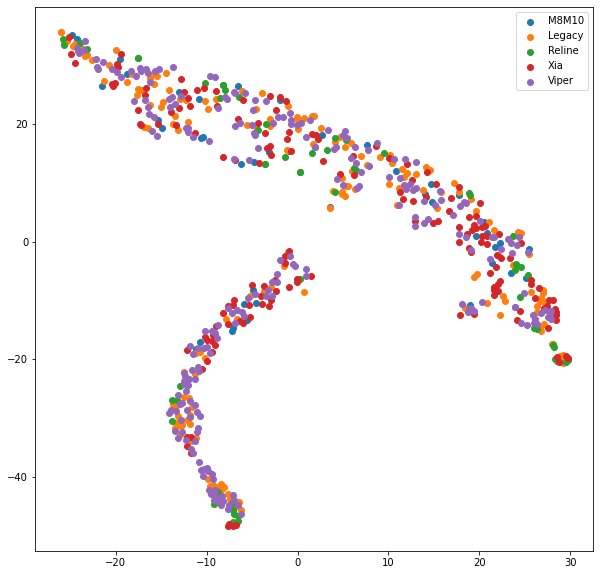

EPOCH:  1  Average Train Loss:  1464.9272911287894
EPOCH:  2  Average Train Loss:  1538.4960379472357
EPOCH:  3  Average Train Loss:  1534.3876967029532
EPOCH:  4  Average Train Loss:  1477.5696280863158
EPOCH:  5  Average Train Loss:  1500.0967592998734
EPOCH:  6  Average Train Loss:  1492.9270045056815
EPOCH:  7  Average Train Loss:  1513.9154857198578
EPOCH:  8  Average Train Loss:  1421.010683368616
EPOCH:  9  Average Train Loss:  1509.3651939369233
EPOCH:  10  Average Train Loss:  1478.9993014304243


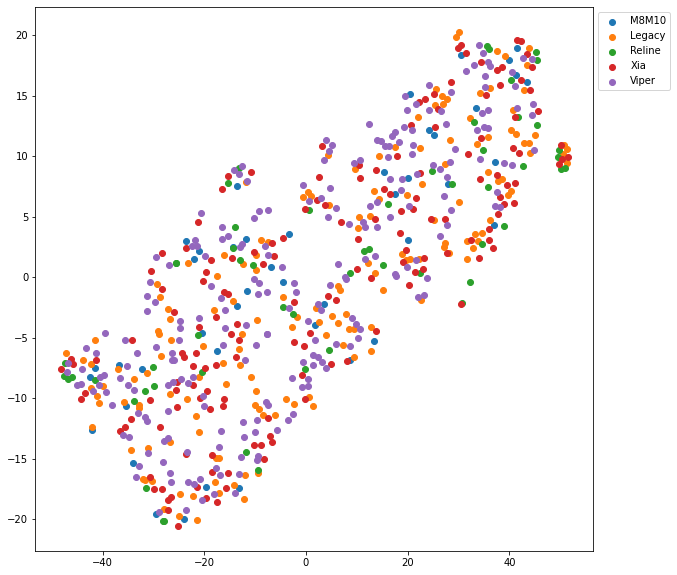

EPOCH:  11  Average Train Loss:  1429.397802308861
EPOCH:  12  Average Train Loss:  1520.8433603348278
EPOCH:  13  Average Train Loss:  1440.1006651986795
EPOCH:  14  Average Train Loss:  1498.4942338922765
EPOCH:  15  Average Train Loss:  1455.5345489276883
EPOCH:  16  Average Train Loss:  1438.980271999938
EPOCH:  17  Average Train Loss:  1492.9996045217054
EPOCH:  18  Average Train Loss:  1472.6209384278493
EPOCH:  19  Average Train Loss:  1426.7066598720394
EPOCH:  20  Average Train Loss:  1427.8639003499432


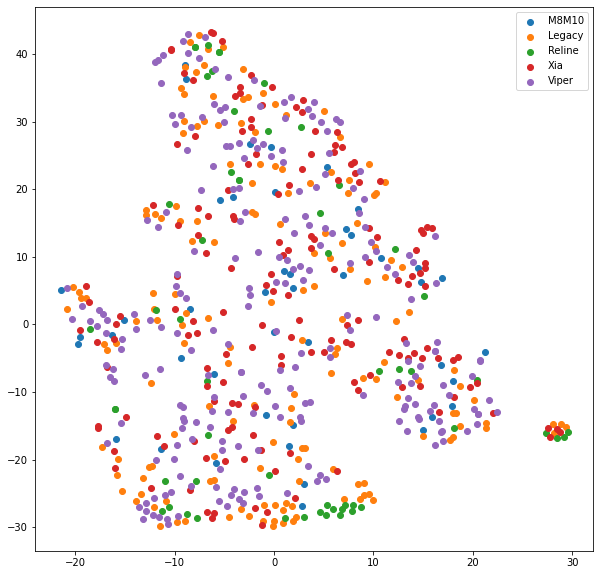

EPOCH:  21  Average Train Loss:  1438.9405358464926
EPOCH:  22  Average Train Loss:  1419.5431236822624
EPOCH:  23  Average Train Loss:  1434.556371585133
EPOCH:  24  Average Train Loss:  1432.0629357552261
EPOCH:  25  Average Train Loss:  1450.8572069933844
EPOCH:  26  Average Train Loss:  1451.0041574370343
EPOCH:  27  Average Train Loss:  1438.4912403911035
EPOCH:  28  Average Train Loss:  1393.051982166484
EPOCH:  29  Average Train Loss:  1474.0905991608956
EPOCH:  30  Average Train Loss:  1499.2914760698134


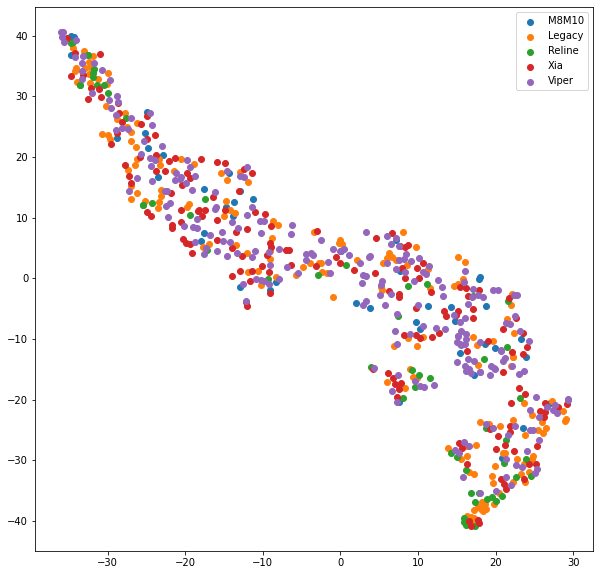

EPOCH:  31  Average Train Loss:  1391.5579339138988
EPOCH:  32  Average Train Loss:  1417.469426057006
EPOCH:  33  Average Train Loss:  1451.654974885194
EPOCH:  34  Average Train Loss:  1409.0384654171946
EPOCH:  35  Average Train Loss:  1426.8138769819861
EPOCH:  36  Average Train Loss:  1517.9567287344394
EPOCH:  37  Average Train Loss:  1409.1873076779275
EPOCH:  38  Average Train Loss:  1394.9193556654768
EPOCH:  39  Average Train Loss:  1380.6971287931424
EPOCH:  40  Average Train Loss:  1373.9610355969564


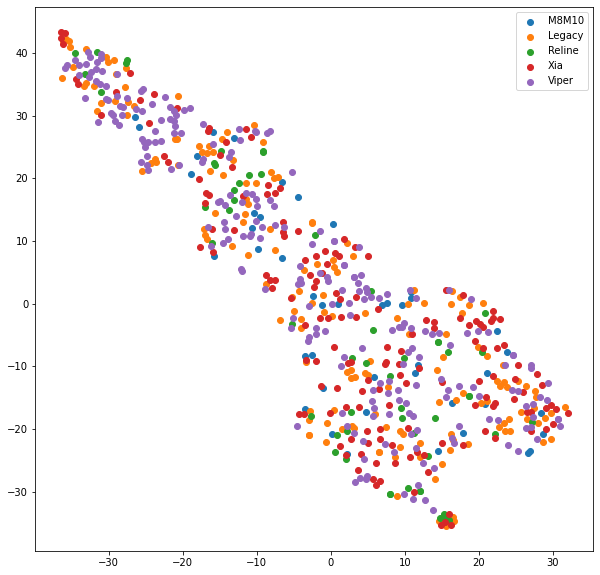

EPOCH:  41  Average Train Loss:  1408.7517966790176
EPOCH:  42  Average Train Loss:  1436.5647051208994
EPOCH:  43  Average Train Loss:  1368.3468436413875
EPOCH:  44  Average Train Loss:  1425.2596718684092
EPOCH:  45  Average Train Loss:  1382.5911115281874
EPOCH:  46  Average Train Loss:  1423.313146908336
EPOCH:  47  Average Train Loss:  1370.9457284951718
EPOCH:  48  Average Train Loss:  1420.5291750530098
EPOCH:  49  Average Train Loss:  1443.0428681943747
EPOCH:  50  Average Train Loss:  1412.4671983731973


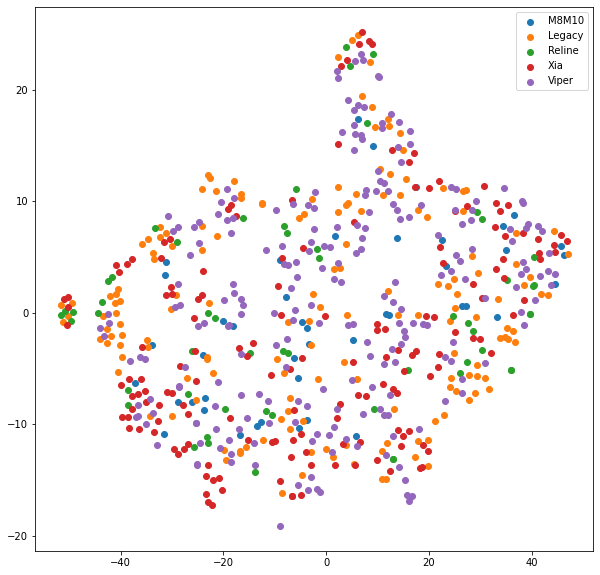

EPOCH:  51  Average Train Loss:  1415.617323676834
EPOCH:  52  Average Train Loss:  1396.3690336152185
EPOCH:  53  Average Train Loss:  1421.355168509865
EPOCH:  54  Average Train Loss:  1329.3928050949933
EPOCH:  55  Average Train Loss:  1387.0336670571635
EPOCH:  56  Average Train Loss:  1435.6902266491159
EPOCH:  57  Average Train Loss:  1393.3157281624551
EPOCH:  58  Average Train Loss:  1408.819111064349
EPOCH:  59  Average Train Loss:  1384.3357099533173
EPOCH:  60  Average Train Loss:  1420.068268478337


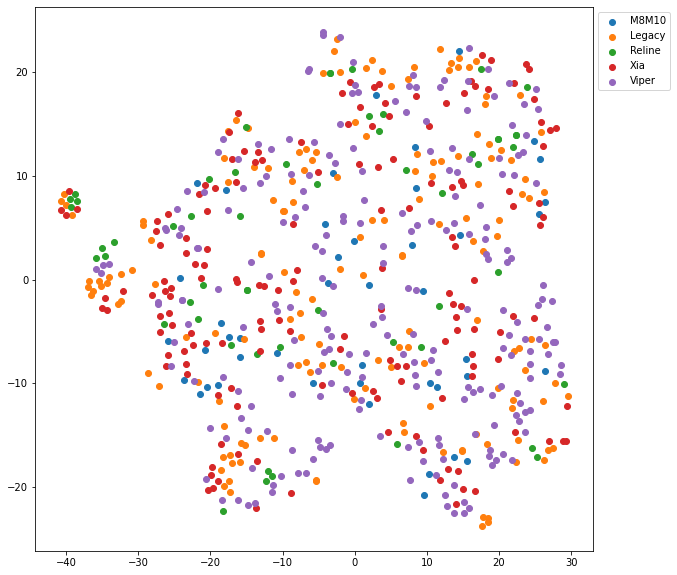

In [ ]:
    '''
    Flags = gflags.FLAGS
    gflags.DEFINE_bool("cuda", True, "use cuda")
    #EDIT THESE
    gflags.DEFINE_string("train_path", "./drive/MyDrive/Cohort May 2021/DataSets/SiameseData_ML/train/", "training folder")
    #gflags.DEFINE_string("test_path", "/home/data/pin/data/omniglot/images_evaluation", 'path of testing folder')
    gflags.DEFINE_integer("way", 20, "how much way one-shot learning")
    #gflags.DEFINE_string("times", 400, "number of samples to test accuracy")
    gflags.DEFINE_integer("workers", 4, "number of dataLoader workers")
    gflags.DEFINE_integer("batch_size", 128, "number of batch size")
    gflags.DEFINE_float("lr", 0.00006, "learning rate")
    gflags.DEFINE_integer("show_every", 10, "show result after each show_every iter.")
    gflags.DEFINE_integer("save_every", 100, "save model after each save_every iter.")
    gflags.DEFINE_integer("test_every", 100, "test model after each test_every iter.")
    gflags.DEFINE_integer("max_iter", 50000, "number of iterations before stopping")
    #gflags.DEFINE_string("model_path", "/home/data/pin/model/siamese", "path to store model")
    gflags.DEFINE_string("gpu_ids", "0,1,2,3", "gpu ids used to train")

    #Flags(sys.argv)
    '''

    data_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomAffine(15),
        transforms.ToTensor()
    ])
    
    #test_df = pd.read_csv(test_path + 'test_df.csv')
    # train_dataset = dset.ImageFolder(root=train_path)
    # test_dataset = dset.ImageFolder(root=test_path)


    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_ids
    print("use gpu:", gpu_ids, "to train.")

    trainSet = ImplantTrain(train_df, train_path, transform=data_transforms)
    #testSet = ImplantTest(test_df, test_path, transform=transforms.ToTensor(), times = times, way = way)
    #testLoader = DataLoader(testSet, batch_size=way, shuffle=False, num_workers=workers)
    trainLoader = DataLoader(trainSet, batch_size=batch_size, shuffle=5, num_workers=workers)

    #loss_fn = torch.nn.BCEWithLogitsLoss(size_average=True)
    criterion = ContrastiveLoss()
    #net = Siamese().to(device)

    # multi gpu
    if len(gpu_ids.split(",")) > 1:
        net = torch.nn.DataParallel(net)

    if cuda:
        net.cuda()

    net.train()
    optimizer = torch.optim.Adam(net.parameters(),lr = lr )
    optimizer.zero_grad()
    time_start = time.time()
    train_loss_list = []
    for epoch in range(EPOCHS):
      train_loss = []
      loss_val = 0
      net.train()
      for batch_id, (img1, img2, label) in enumerate(trainLoader, 1):
          #print(label)
          #if batch_id > max_iter:
          #    break
          if cuda:
              img1, img2, label = Variable(img1.cuda()), Variable(img2.cuda()), Variable(label.cuda())
          else:
              img1, img2, label = Variable(img1), Variable(img2), Variable(label)
          optimizer.zero_grad()
          #output1, output2 = net.forward(img1, img2)
          output1 = net(img1)
          output2 = net(img2)
          loss = criterion(output1, output2, label)
          loss_val += loss.item()
          loss.backward()
          optimizer.step()
          #if batch_id % show_every == 0 :
          #    print('[%d]\tloss:\t%.5f\ttime lapsed:\t%.2f s'%(batch_id, loss_val/show_every, time.time() - time_start))
          #    loss_val = 0
          #    time_start = time.time()
          '''
          if batch_id % save_every == 0:
              torch.save(net.state_dict(), model_path + '/model-inter-' + str(batch_id+1) + ".pt")
          if batch_id % test_every == 0:
              right, error = 0, 0
              for _, (test1, test2) in enumerate(testLoader, 1):
                  if cuda:
                      test1, test2 = test1.cuda(), test2.cuda()
                  test1, test2 = Variable(test1), Variable(test2)
                  output = net.forward(test1, test2).data.cpu().numpy()
                  pred = np.argmax(output)
                  if pred == 0:
                      right += 1
                  else: error += 1
              print('*'*70)
              print('[%d]\tTest set\tcorrect:\t%d\terror:\t%d\tprecision:\t%f'%(batch_id, right, error, right*1.0/(right+error)))
              print('*'*70)
              queue.append(right*1.0/(right+error))
          '''
          train_loss.append(loss_val)
      trainloss = sum(train_loss)/len(train_loss)
      print("EPOCH: ", epoch, " Average Train Loss: ", trainloss)
      train_loss_list.append(trainloss)
      train_embeddings, test_embeddings, train_labels, test_labels = get_embeddings(trainloader__=trainloader__, testloader__=testloader__, model=net)
      if epoch % 10 == 0:
        embeddings(train_embeddings, train_labels)
      #test()

      #  learning_rate = learning_rate * 0.95

# Saving model for inference

In [ ]:
PATH = './drive/MyDrive/Cohort May 2021/models/siamese_firstry.pt'

In [ ]:
torch.save(net.state_dict(), PATH)



In [ ]:
#Later to restore:
net = Siamese()

net.load_state_dict(torch.load(PATH))
net.eval()

RuntimeError: ignored

In [ ]:
class DATASET_Loader(Dataset):
    def __init__(self, df,transform=None):
        np.random.seed(1)
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform
        #self.label_mapper = label_mapper

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.df['file_path'].iloc[idx]
        #print(img_name)
        image = cv2.imread(img_name)
        label = self.df['Product'].iloc[idx]
        #label = self.label_mapper[label]

        

        if self.transform:
            image = self.transform(image)
        #sample = {'image': image, 'Label': label}
        return image, label

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Wed Jun  9 21:30:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    33W /  70W |   7306MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------